# Lab 7: Optimization and Regularization 

Authored by Nithish Addepalli and Ren Yi, 3-26-2020;
Modified by Runyu Hong, 3-25-2021;

The goal of this lab is to learn how to apply different regularization and optimization strategies in PyTorch using MNIST data.

Here is a list of the techniques we've covered in class
- Optimization
    - SGD
    - SGD (with momentum)
    - Nesterov momentum
    - AdaGrad
    - RMSProp
    - Adam
- Some regularization
    - Dropout
    - Batch normalization

 

## Problem Setup

In [1]:
import time
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Initialize necessary parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(717)

seed = 345
batch_size = {'train': 64,
              'val': 1000}
input_size = 28 * 28
output_size = 10
n_feature = 3
optim_results = {}

In [3]:
# Data Loader
trainset = datasets.MNIST('data', train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))]))
testset = datasets.MNIST('data', train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))]))

mnist_datasets = {'train': trainset, 
            'val': testset}
dataset_sizes = {x: len(mnist_datasets[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(mnist_datasets[x], batch_size=batch_size[x], shuffle=True)
              for x in ['train', 'val']}

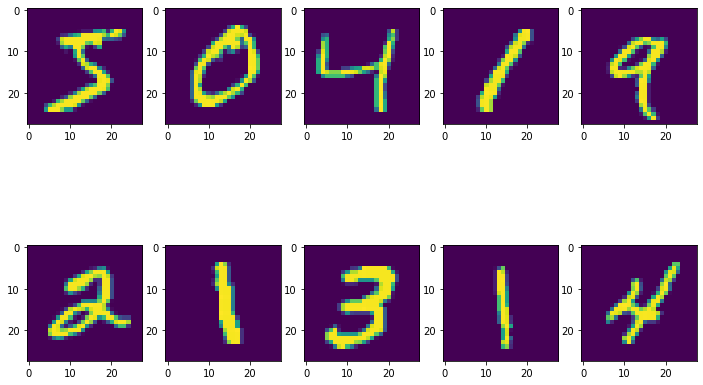

In [4]:
## show some images
plt.figure(figsize = (12, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = dataloaders['train'].dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())

In [5]:
def train_model(model, optimizer, num_epochs=1, verbose = True, print_every = 100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {'train': [], 'val': []}
    
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, data in enumerate(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size()[0]
                running_corrects += torch.sum(preds == labels).item()
                
                if verbose and batch_idx % print_every == 0:
                    print('Train set | epoch: {:3d} | {:6d}/{:6d} batches | Loss: {:6.4f}'.format(
                        epoch, batch_idx * len(inputs), len(dataloaders[phase].dataset), loss.item()))
                    loss_dict[phase].append(running_loss/((batch_idx + 1) * len(inputs)))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_dict

def populate_result(dictionary, method, train_loss, val_loss):
    dictionary[method] = {}
    dictionary[method]['train_loss'] = np.array(train_loss)
    dictionary[method]['val_loss'] = np.array(val_loss)
    
def plot_loss(result, loss='train_loss', ylim=None):
    plt.plot(result['Baseline'][loss], label='Baseline')
    for k in result.keys():
        if k != 'Baseline':
            plt.plot(result[k][loss], label=k)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_best_loss(result, loss='val_loss'):
    labels = ['Baseline']
    acc = [np.max(result['Baseline'][loss])]
    for k in result.keys():
        if k != 'Baseline':
            labels.append(k)
            acc.append(np.max(result[k][loss]))

    x = np.arange(len(labels))
    plt.barh(x, acc)
    plt.yticks(x, labels)
    plt.xlabel('Loss')
    plt.show()

### Baseline method

We will later show how different optimization and regularization techniques can improve baseline model performance. But first,
1. What's our baseline model architecture?
2. What's the optimization method used to train the baseline model?
3. How does this optimization method update its parameters.
$$\theta_{t+1} = \theta_{t} - \eta \nabla J(\theta_{t})$$
where $\eta$ denotes the learning rate

In [6]:
class Baseline(nn.Module):
    def __init__(self, n_feature, output_size):
        super(Baseline, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.ReLU(),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [7]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Baseline', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3152
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 2.2778
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 2.2295
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 1.2612
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.8846
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.4914
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.4499
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.4444
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.6363
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.4161
train Loss: 1.0644 Acc: 0.6470
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.3766
val Loss: 0.4272 Acc: 0.8657

Training complete in 0m 19s
Best val Acc: 0.865700


## Fancier Optimization

https://pytorch.org/docs/stable/optim.html

### SGD with momentum
1. How does SGD with momentum update its parameters?
$$v_{t+1} = \rho v_{t} + \nabla J(\theta_{t})$$
$$\theta_{t+1} = \theta_{t} - \eta v_{t+1}$$
where $v$ and $\rho$ denote velocity and momentum, respectively.
2. Check out the documentation for SGD in PyTorch and complete the code below (Set momentum=0.5). 

In [8]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.5)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'SGD_momentum', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3152
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 2.1852
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.6592
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.4649
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.6572
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.2936
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.3270
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.3324
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.5616
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.2375
train Loss: 0.7233 Acc: 0.7654
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.2585
val Loss: 0.3085 Acc: 0.9050

Training complete in 0m 19s
Best val Acc: 0.905000


### Nesterov momentum

Make a minor change in the above code to apply Nesterov momentum (Set momentum=0.5). 

In [9]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.5, nesterov=True)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Nesterov_momentum', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3152
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 2.1808
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.7534
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.4704
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.6746
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.3131
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.3202
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.3455
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.5697
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.2484
train Loss: 0.7227 Acc: 0.7654
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.2765
val Loss: 0.3201 Acc: 0.9029

Training complete in 0m 19s
Best val Acc: 0.902900


### AdaGrad

In [10]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.Adagrad(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Adagrad', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3152
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 0.3807
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.3336
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.3232
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.5752
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.2350
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.2919
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.2990
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.4286
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.2054
train Loss: 0.3846 Acc: 0.8823
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.2301
val Loss: 0.2595 Acc: 0.9242

Training complete in 0m 19s
Best val Acc: 0.924200


### RMSprop

In [11]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.RMSprop(model.parameters(),lr=0.01, alpha=0.9)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'RMSprop', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3152
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 0.1885
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.2434
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.1513
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.1916
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.1740
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.3271
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.1654
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.1158
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.0220
train Loss: 0.2743 Acc: 0.9121
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.1260
val Loss: 0.1868 Acc: 0.9405

Training complete in 0m 21s
Best val Acc: 0.940500


### Adam

In [12]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01, betas=(0.9, 0.99))
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Adam', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3152
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 0.2051
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.1856
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.2332
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.1820
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.1328
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.1631
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.2054
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.3433
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.0672
train Loss: 0.2513 Acc: 0.9209
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.1518
val Loss: 0.1918 Acc: 0.9423

Training complete in 0m 20s
Best val Acc: 0.942300


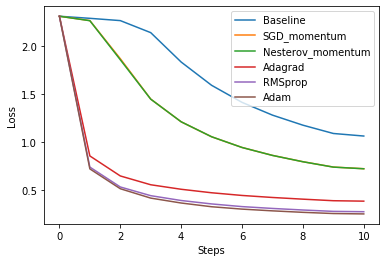

In [13]:
# Plot optimization methods training results
plot_loss(optim_results)

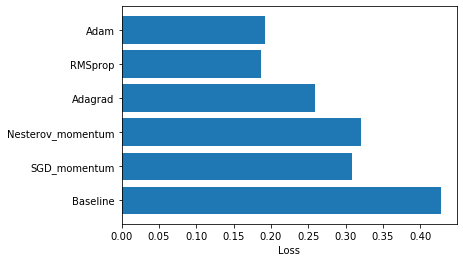

In [14]:
# Plot optimization methods validation results
plot_best_loss(optim_results)

## Regularization

https://pytorch.org/docs/stable/nn.html

In [15]:
# In order to see effects of regularization on validation set, we need to make some slight modification

## Smaller training set
mnist_datasets['train'].data = mnist_datasets['train'].data[:600]
dataset_sizes = {x: len(mnist_datasets[x]) for x in ['train', 'val']}
dataloaders['train'] = torch.utils.data.DataLoader(mnist_datasets['train'], 
                                                   batch_size=batch_size['train'], shuffle=True)

## Longer training epochs
train_epochs = 25
verbose = False
reg_results = {}

### Baseline model

In [16]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer, num_epochs=train_epochs, verbose=verbose)
populate_result(reg_results, 'Baseline', loss_dict['train'], loss_dict['val'])

Epoch 0/24
----------
train Loss: 2.0973 Acc: 0.2650
val Loss: 1.4374 Acc: 0.5660

Epoch 1/24
----------
train Loss: 0.9714 Acc: 0.7200
val Loss: 0.9179 Acc: 0.7055

Epoch 2/24
----------
train Loss: 0.6271 Acc: 0.8100
val Loss: 0.7293 Acc: 0.7433

Epoch 3/24
----------
train Loss: 0.4617 Acc: 0.8683
val Loss: 0.5667 Acc: 0.8168

Epoch 4/24
----------
train Loss: 0.3390 Acc: 0.8967
val Loss: 0.4734 Acc: 0.8514

Epoch 5/24
----------
train Loss: 0.2503 Acc: 0.9167
val Loss: 0.4775 Acc: 0.8522

Epoch 6/24
----------
train Loss: 0.1736 Acc: 0.9483
val Loss: 0.4296 Acc: 0.8776

Epoch 7/24
----------
train Loss: 0.1527 Acc: 0.9483
val Loss: 0.6078 Acc: 0.8320

Epoch 8/24
----------
train Loss: 0.1451 Acc: 0.9500
val Loss: 0.5243 Acc: 0.8608

Epoch 9/24
----------
train Loss: 0.1138 Acc: 0.9533
val Loss: 0.5751 Acc: 0.8527

Epoch 10/24
----------
train Loss: 0.1607 Acc: 0.9450
val Loss: 0.4994 Acc: 0.8657

Epoch 11/24
----------
train Loss: 0.0926 Acc: 0.9650
val Loss: 0.5283 Acc: 0.8647

Ep

### L1/L2 regularization

L2 regularization is included in most optimizers in PyTorch and can be controlled with the __weight_decay__ parameter.
For L1 regularization, check out this post: https://discuss.pytorch.org/t/simple-l2-regularization/139

### Adding Dropout Layer

1. Check out documentations for __nn.Dropout()__. Modify the Baseline model and add dropout layer to the fully connected layers.
2. Optionally, you may also check out documentations for __nn.Dropout2d()__ to learn how to add Dropout layer to convolution layers.

In [17]:
class DropoutNet(nn.Module):
    def __init__(self, input_size, n_feature, output_size, dropout_rate=0.5):
        super(DropoutNet, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.ReLU(),
                                nn.Dropout(dropout_rate),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [18]:
torch.manual_seed(seed)
model = DropoutNet(input_size, n_feature, output_size, dropout_rate=0.3).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer, num_epochs=train_epochs, verbose=verbose)
populate_result(reg_results, 'Dropout', loss_dict['train'], loss_dict['val'])

Epoch 0/24
----------
train Loss: 2.1650 Acc: 0.2350
val Loss: 1.6361 Acc: 0.5079

Epoch 1/24
----------
train Loss: 1.2514 Acc: 0.5617
val Loss: 0.9138 Acc: 0.6785

Epoch 2/24
----------
train Loss: 0.8508 Acc: 0.7283
val Loss: 0.7697 Acc: 0.7395

Epoch 3/24
----------
train Loss: 0.6833 Acc: 0.7783
val Loss: 0.6424 Acc: 0.7861

Epoch 4/24
----------
train Loss: 0.5876 Acc: 0.8033
val Loss: 0.5845 Acc: 0.8011

Epoch 5/24
----------
train Loss: 0.4666 Acc: 0.8383
val Loss: 0.5325 Acc: 0.8251

Epoch 6/24
----------
train Loss: 0.3696 Acc: 0.8750
val Loss: 0.5006 Acc: 0.8407

Epoch 7/24
----------
train Loss: 0.3442 Acc: 0.8933
val Loss: 0.4694 Acc: 0.8536

Epoch 8/24
----------
train Loss: 0.3223 Acc: 0.8917
val Loss: 0.5297 Acc: 0.8303

Epoch 9/24
----------
train Loss: 0.2590 Acc: 0.9017
val Loss: 0.4586 Acc: 0.8572

Epoch 10/24
----------
train Loss: 0.2634 Acc: 0.9000
val Loss: 0.4618 Acc: 0.8596

Epoch 11/24
----------
train Loss: 0.1714 Acc: 0.9383
val Loss: 0.4644 Acc: 0.8710

Ep

### Adding Batch Normalization
1. What's the advantage of using batch normalization?
    1. Allow each layer to train relatively more independently
    2. Improve gradient flow through the network
    3. Allows higher learning rate
    4. Reduces strong dependence on initialization
2. Implement batch normalization in __BatchnormNet__. Think about where you may want to insert the batch normalization layer.

In [19]:
class BatchnormNet(nn.Module):
    def __init__(self, n_feature, output_size):
        super(BatchnormNet, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.BatchNorm2d(n_feature),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.BatchNorm2d(n_feature),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.BatchNorm1d(50),
                                nn.ReLU(),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [20]:
torch.manual_seed(seed)
model = BatchnormNet(n_feature, output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer, num_epochs=train_epochs, verbose=verbose)
populate_result(reg_results, 'Batchnorm', loss_dict['train'], loss_dict['val'])

Epoch 0/24
----------
train Loss: 1.6971 Acc: 0.5100
val Loss: 1.4720 Acc: 0.5368

Epoch 1/24
----------
train Loss: 0.8019 Acc: 0.8267
val Loss: 0.8003 Acc: 0.7447

Epoch 2/24
----------
train Loss: 0.4420 Acc: 0.8733
val Loss: 0.5799 Acc: 0.8084

Epoch 3/24
----------
train Loss: 0.2850 Acc: 0.9217
val Loss: 0.4652 Acc: 0.8451

Epoch 4/24
----------
train Loss: 0.1766 Acc: 0.9550
val Loss: 0.5399 Acc: 0.8196

Epoch 5/24
----------
train Loss: 0.1297 Acc: 0.9767
val Loss: 0.4196 Acc: 0.8613

Epoch 6/24
----------
train Loss: 0.1023 Acc: 0.9750
val Loss: 0.3952 Acc: 0.8720

Epoch 7/24
----------
train Loss: 0.0797 Acc: 0.9833
val Loss: 0.3759 Acc: 0.8773

Epoch 8/24
----------
train Loss: 0.0629 Acc: 0.9933
val Loss: 0.4404 Acc: 0.8594

Epoch 9/24
----------
train Loss: 0.0492 Acc: 0.9883
val Loss: 0.3600 Acc: 0.8829

Epoch 10/24
----------
train Loss: 0.0403 Acc: 0.9950
val Loss: 0.3787 Acc: 0.8820

Epoch 11/24
----------
train Loss: 0.0384 Acc: 0.9933
val Loss: 0.4003 Acc: 0.8777

Ep

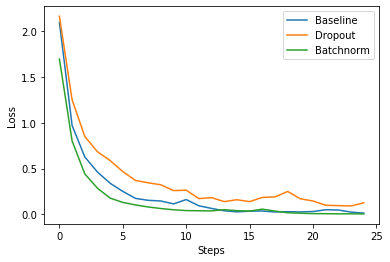

In [21]:
plot_loss(reg_results)

Validation loss using Dropout and Batchnorm start to catch up with the loss of baseline model after baseline model overfits training data.

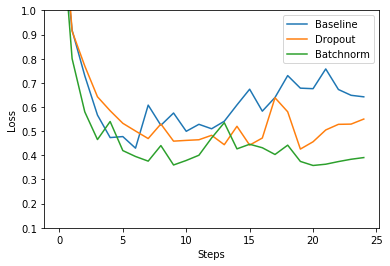

In [22]:
plot_loss(reg_results, loss = 'val_loss', ylim=(0.1, 1))

## Exercise: parameter tunning

We've introduced multiple regularization and optimization techniques to improve your model. How can you combine these techniques and perform grid search to find out a set of parameters that maximize your model performance on validation set? Are there other model architectures you'd like to try?